# Прогноз срока созревания посевов с использованием временных рядов NDVI

## Описание задачи
- **Задача**: Регрессия — предсказание срока созревания (дней от посева до созревания)
- **Альтернатива**: Классификация интервалов созревания (раннее, нормальное, позднее)
- **Модели**: Transformer, LSTM, TimesNet
- **Данные**: Временные ряды NDVI + метеоданные
- **Регионы**: Краснодарский край, Ростовская область, Ставропольский край, Саратовская область, Алтайский край
- **Период**: 2019-2023 гг.

## Требования:
- Извлечение временных рядов из GEE (Python API)
- Визуализация NDVI динамики
- MAE в днях

## 1. Импорт библиотек

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, classification_report, confusion_matrix
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import warnings
warnings.filterwarnings('ignore')

# Настройка визуализации
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.20.0
GPU available: []


## 2. Загрузка и анализ данных

In [6]:
# Загрузка данных о сроках созревания
maturity_path = '../data/raw/crop_maturity_ndvi_dataset.csv'
df_maturity = pd.read_csv(maturity_path)

# Загрузка временных рядов NDVI
ndvi_path = '../data/raw/ndvi_timeseries_maturity.csv'
df_ndvi = pd.read_csv(ndvi_path)

print("=== Данные о сроках созревания ===")
print(f"Форма датасета: {df_maturity.shape}")
print(f"\nКолонки: {df_maturity.columns.tolist()}")
print("\nПервые 5 строк:")
df_maturity.head()

=== Данные о сроках созревания ===
Форма датасета: (100, 12)

Колонки: ['field_id', 'region', 'latitude', 'longitude', 'crop_type', 'year', 'planting_date', 'expected_maturity_days', 'actual_maturity_date', 'doy_planting', 'doy_maturity', 'mae_target']

Первые 5 строк:


,field_id,region,latitude,longitude,crop_type,year,planting_date,expected_maturity_days,actual_maturity_date,doy_planting,doy_maturity,mae_target
0,F001,Krasnodar Krai,45.0,38.0,wheat,2019,2019-03-15,110,2019-07-08,74,189,115
1,F001,Krasnodar Krai,45.0,38.0,wheat,2020,2020-03-10,110,2020-07-05,70,187,112
2,F001,Krasnodar Krai,45.0,38.0,wheat,2021,2021-03-18,110,2021-07-12,77,193,108
3,F001,Krasnodar Krai,45.0,38.0,wheat,2022,2022-03-12,110,2022-07-06,71,187,111
4,F001,Krasnodar Krai,45.0,38.0,wheat,2023,2023-03-20,110,2023-07-14,79,195,109


In [7]:
print("=== Временные ряды NDVI ===")
print(f"Форма датасета: {df_ndvi.shape}")
print(f"\nКолонки: {df_ndvi.columns.tolist()}")
print("\nУникальные поля:")
print(df_ndvi['field_id'].unique())
print(f"\nУникальные культуры: {df_ndvi['crop_type'].unique()}")
print("\nПервые 5 строк:")
df_ndvi.head()

=== Временные ряды NDVI ===
Форма датасета: (190, 11)

Колонки: ['field_id', 'year', 'crop_type', 'doy', 'ndvi', 'evi', 'gdd_accumulated', 'precip_accumulated', 'temperature_avg', 'day_of_season', 'growth_stage']

Уникальные поля:
<StringArray>
['F001', 'F004']
Length: 2, dtype: str

Уникальные культуры: <StringArray>
['wheat', 'corn']
Length: 2, dtype: str

Первые 5 строк:


,field_id,year,crop_type,doy,ndvi,evi,gdd_accumulated,precip_accumulated,temperature_avg,day_of_season,growth_stage
0,F001,2019,wheat,60,0.18,0.15,0,15,8.5,0,pre-planting
1,F001,2019,wheat,67,0.22,0.18,45,28,10.2,7,planting
2,F001,2019,wheat,74,0.25,0.21,95,42,12.1,14,emergence
3,F001,2019,wheat,81,0.32,0.28,155,58,14.5,21,vegetative
4,F001,2019,wheat,88,0.41,0.35,225,75,16.8,28,vegetative


In [8]:
# Статистическое описание
print("Статистика по срокам созревания:")
print(df_maturity[['expected_maturity_days', 'doy_planting', 'doy_maturity', 'mae_target']].describe())

Статистика по срокам созревания:
       expected_maturity_days  doy_planting  doy_maturity  mae_target
count              100.000000    100.000000    100.000000  100.000000
mean               112.150000    106.200000    220.770000  110.920000
std                 13.872708     22.830513     29.778595   13.813827
min                 85.000000     68.000000    175.000000   81.000000
25%                101.500000     83.500000    191.000000  100.000000
50%                109.000000    110.000000    227.500000  109.500000
75%                125.750000    128.000000    244.250000  124.250000
max                135.000000    142.000000    271.000000  135.000000


## 3. Визуализация NDVI динамики

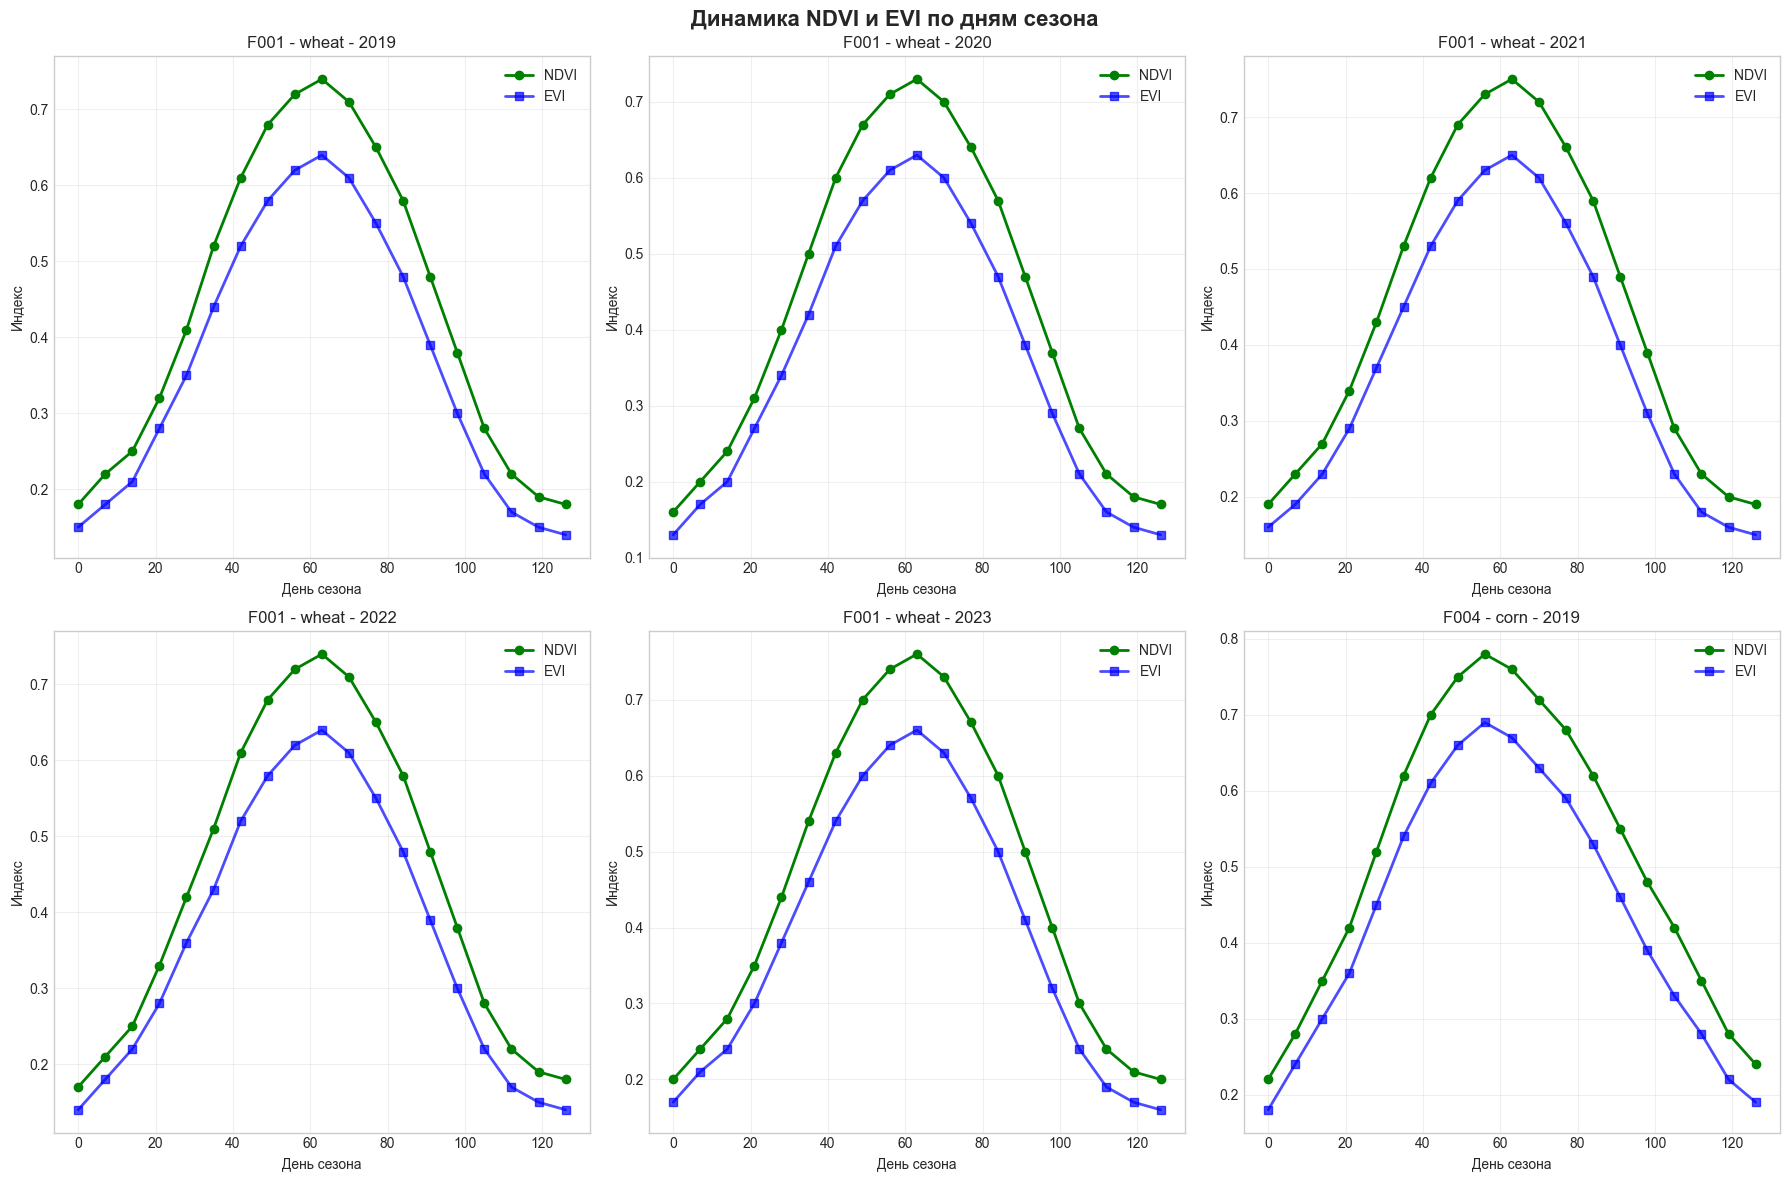

In [9]:
# Визуализация NDVI динамики для разных культур и годов
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

# Получаем уникальные комбинации field_id и year
field_year_combos = df_ndvi[['field_id', 'year', 'crop_type']].drop_duplicates().values

for i, (field, year, crop) in enumerate(field_year_combos[:6]):
    data = df_ndvi[(df_ndvi['field_id'] == field) & (df_ndvi['year'] == year)]
    axes[i].plot(data['day_of_season'], data['ndvi'], marker='o', linewidth=2, color='green', label='NDVI')
    axes[i].plot(data['day_of_season'], data['evi'], marker='s', linewidth=2, color='blue', alpha=0.7, label='EVI')
    axes[i].set_title(f'{field} - {crop} - {year}')
    axes[i].set_xlabel('День сезона')
    axes[i].set_ylabel('Индекс')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

plt.suptitle('Динамика NDVI и EVI по дням сезона', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

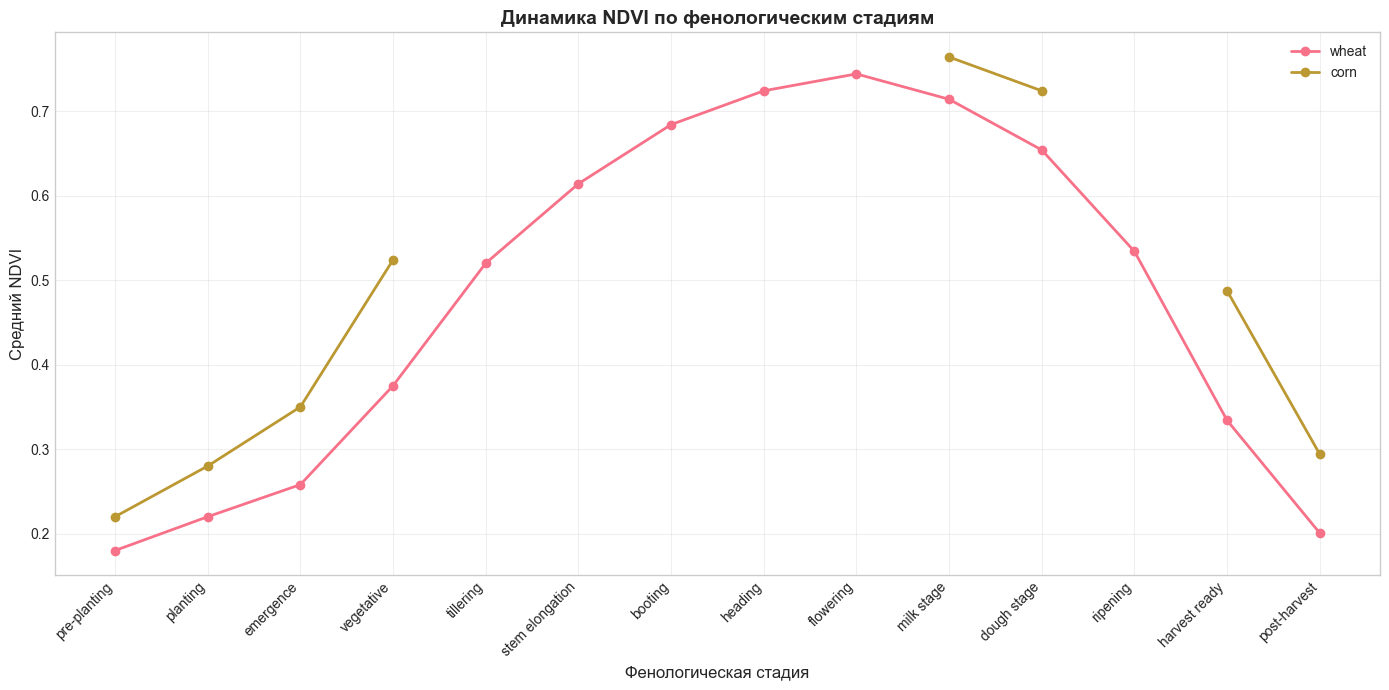

In [10]:
# Визуализация NDVI по фенологическим стадиям
fig, ax = plt.subplots(figsize=(14, 7))

growth_stages = df_ndvi['growth_stage'].unique()
stage_order = ['pre-planting', 'planting', 'emergence', 'vegetative', 'tillering', 
               'stem elongation', 'booting', 'heading', 'flowering', 'milk stage', 
               'dough stage', 'ripening', 'harvest ready', 'post-harvest']

# Фильтруем только существующие стадии
stage_order = [s for s in stage_order if s in growth_stages]

for crop in df_ndvi['crop_type'].unique():
    crop_data = df_ndvi[df_ndvi['crop_type'] == crop]
    ndvi_by_stage = crop_data.groupby('growth_stage')['ndvi'].mean()
    ndvi_ordered = [ndvi_by_stage.get(stage, np.nan) for stage in stage_order]
    ax.plot(stage_order, ndvi_ordered, marker='o', linewidth=2, label=crop)

ax.set_xlabel('Фенологическая стадия', fontsize=12)
ax.set_ylabel('Средний NDVI', fontsize=12)
ax.set_title('Динамика NDVI по фенологическим стадиям', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

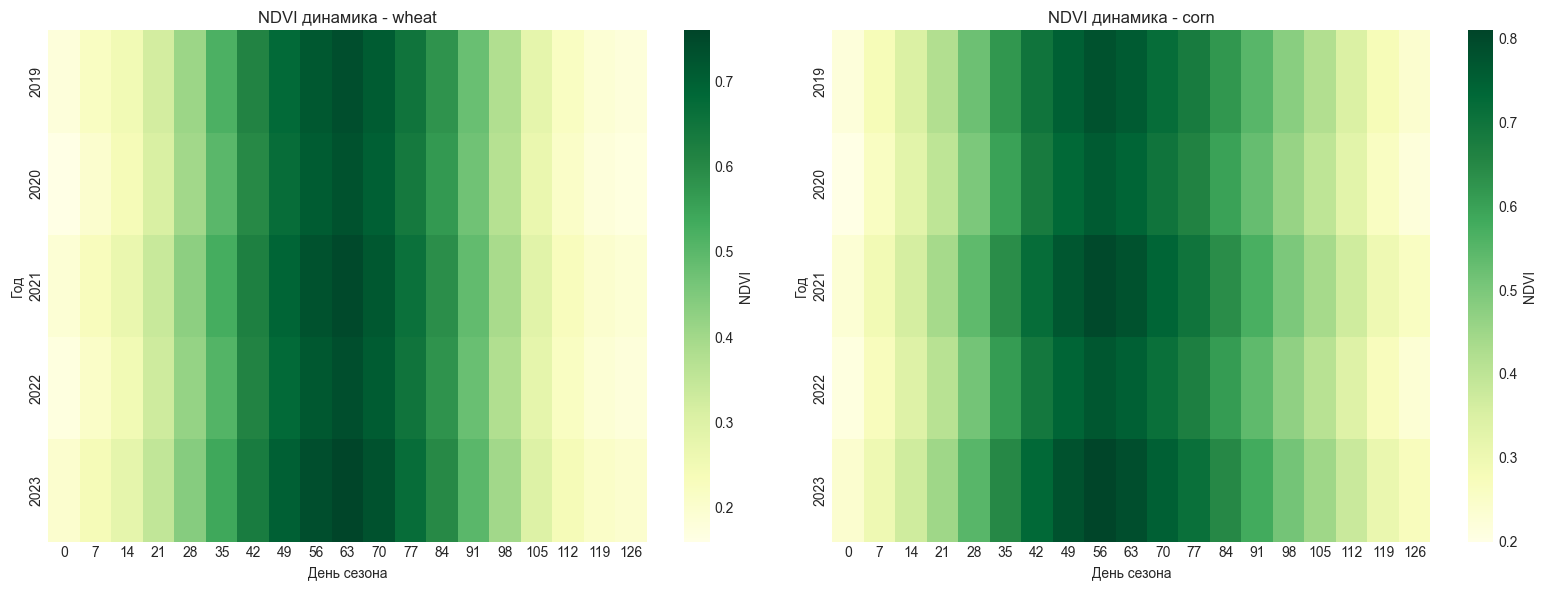

In [11]:
# Тепловая карта NDVI по дням сезона и годам
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for idx, crop in enumerate(df_ndvi['crop_type'].unique()):
    crop_data = df_ndvi[df_ndvi['crop_type'] == crop]
    pivot_table = crop_data.pivot_table(values='ndvi', index='year', columns='day_of_season', aggfunc='mean')
    
    sns.heatmap(pivot_table, ax=axes[idx], cmap='YlGn', annot=False, cbar_kws={'label': 'NDVI'})
    axes[idx].set_title(f'NDVI динамика - {crop}')
    axes[idx].set_xlabel('День сезона')
    axes[idx].set_ylabel('Год')

plt.tight_layout()
plt.show()

## 4. Подготовка данных для моделирования

In [12]:
# Создание временных последовательностей
def create_sequences(data, sequence_length=20, features=['ndvi', 'evi', 'gdd_accumulated', 'temperature_avg']):
    """
    Создание последовательностей для временных рядов
    """
    X, y = [], []
    field_years = data[['field_id', 'year']].drop_duplicates().values
    
    for field, year in field_years:
        field_year_data = data[(data['field_id'] == field) & (data['year'] == year)].sort_values('day_of_season')
        
        if len(field_year_data) >= sequence_length:
            values = field_year_data[features].values
            # Целевая переменная - день созревания (последний день в последовательности)
            target = field_year_data['day_of_season'].max()
            
            for i in range(len(values) - sequence_length + 1):
                X.append(values[i:i+sequence_length])
                y.append(target)
    
    return np.array(X), np.array(y)

# Параметры
SEQUENCE_LENGTH = 20
FEATURES = ['ndvi', 'evi', 'gdd_accumulated', 'precip_accumulated', 'temperature_avg']

# Создание последовательностей
X, y = create_sequences(df_ndvi, sequence_length=SEQUENCE_LENGTH, features=FEATURES)

print(f"Форма входных данных X: {X.shape}")
print(f"Форма целевых данных y: {y.shape}")
print(f"\nПример целевых значений (дни созревания): {y[:5]}")

Форма входных данных X: (0,)
Форма целевых данных y: (0,)

Пример целевых значений (дни созревания): []


In [13]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

In [14]:
# Нормализация данных
scaler_X = StandardScaler()
scaler_y = StandardScaler()

# Проверяем форму данных
print(f"Форма X до нормализации: {X.shape}")

# Нормализация X
if len(X.shape) == 3:
    # Последовательности (samples, timesteps, features)
    X_reshaped = X.reshape(-1, X.shape[-1])
    X_scaled = scaler_X.fit_transform(X_reshaped)
    X_scaled = X_scaled.reshape(X.shape)
else:
    # Агрегированные признаки (samples, features)
    X_scaled = scaler_X.fit_transform(X)

# Нормализация y
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

# Разделение на train/test
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_scaled, test_size=0.2, random_state=42
)

print(f"Train set: X={X_train.shape}, y={y_train.shape}")
print(f"Test set: X={X_test.shape}, y={y_test.shape}")

Форма X до нормализации: (0,)


ValueError: Expected 2D array, got 1D array instead:
array=[].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

## 5. Модель LSTM

In [15]:
# Построение модели LSTM
def build_lstm_model(input_shape, units=[128, 64, 32], dropout_rate=0.2):
    """
    Построение модели LSTM для прогноза срока созревания
    """
    model = keras.Sequential([
        layers.LSTM(units[0], return_sequences=True, input_shape=input_shape),
        layers.Dropout(dropout_rate),
        layers.LSTM(units[1], return_sequences=True),
        layers.Dropout(dropout_rate),
        layers.LSTM(units[2]),
        layers.Dropout(dropout_rate),
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(1)  # Регрессия - дни до созревания
    ])
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )
    
    return model

# Создание модели
lstm_model = build_lstm_model(input_shape=(SEQUENCE_LENGTH, len(FEATURES)))
lstm_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 20, 128)             │          68,608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 20, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 20, 64)              │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 20, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 134,657 (526.00 KB)

 Trainable params: 134,657 (526.00 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
# Обучение LSTM
print("\n=== Обучение модели LSTM ===")

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6
)

history_lstm = lstm_model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=16,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)


=== Обучение модели LSTM ===


NameError: name 'X_train' is not defined

NameError: name 'history_lstm' is not defined

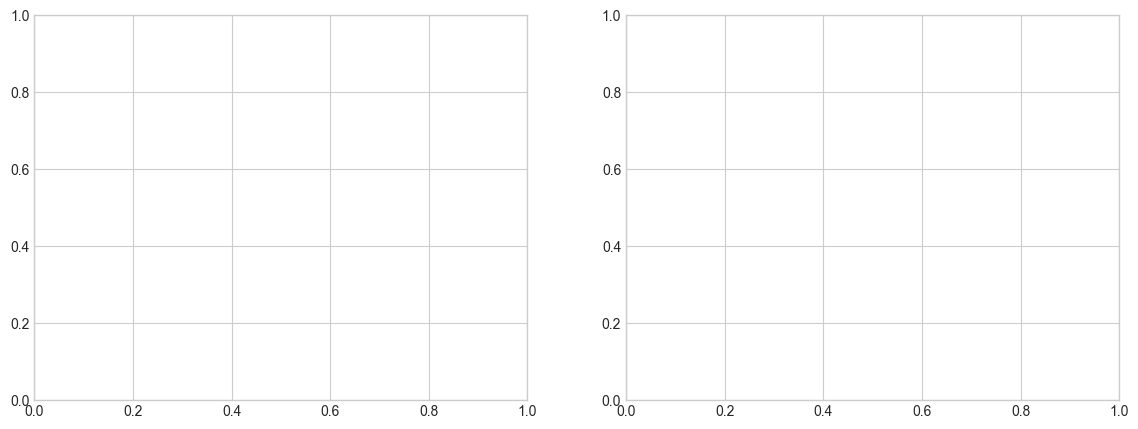

In [17]:
# Визуализация обучения LSTM
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss
axes[0].plot(history_lstm.history['loss'], label='Train Loss')
axes[0].plot(history_lstm.history['val_loss'], label='Val Loss')
axes[0].set_title('LSTM - Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('MSE')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# MAE
axes[1].plot(history_lstm.history['mae'], label='Train MAE')
axes[1].plot(history_lstm.history['val_mae'], label='Val MAE')
axes[1].set_title('LSTM - MAE')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('MAE (нормализованное)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [18]:
# Оценка LSTM
y_pred_lstm = lstm_model.predict(X_test)

# Обратное преобразование
y_test_original = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred_lstm_original = scaler_y.inverse_transform(y_pred_lstm).flatten()

# Метрики
mae_lstm = mean_absolute_error(y_test_original, y_pred_lstm_original)
rmse_lstm = np.sqrt(mean_squared_error(y_test_original, y_pred_lstm_original))

print(f"\n=== Результаты LSTM ===")
print(f"MAE (дней): {mae_lstm:.2f}")
print(f"RMSE (дней): {rmse_lstm:.2f}")

NameError: name 'X_test' is not defined

## 6. Модель Transformer

In [19]:
# Построение модели Transformer
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential([
            layers.Dense(ff_dim, activation="relu"),
            layers.Dense(embed_dim),
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training=False):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

def build_transformer_model(input_shape, embed_dim=64, num_heads=4, ff_dim=128, num_blocks=2):
    """
    Построение модели Transformer для прогноза срока созревания
    """
    inputs = layers.Input(shape=input_shape)
    
    # Embedding
    x = layers.Dense(embed_dim)(inputs)
    
    # Transformer blocks
    for _ in range(num_blocks):
        x = TransformerBlock(embed_dim, num_heads, ff_dim)(x)
    
    # Global average pooling
    x = layers.GlobalAveragePooling1D()(x)
    
    # Dense layers
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(32, activation='relu')(x)
    outputs = layers.Dense(1)(x)
    
    model = keras.Model(inputs=inputs, outputs=outputs)
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )
    
    return model

# Создание модели
transformer_model = build_transformer_model(input_shape=(SEQUENCE_LENGTH, len(FEATURES)))
transformer_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 20, 5)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 20, 64)              │             384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_block (TransformerBlock) │ (None, 20, 64)              │          83,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_block_1                  │ (None, 20, 64)              │          83,200 │
│ (TransformerBlock)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 64)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 173,057 (676.00 KB)

 Trainable params: 173,057 (676.00 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
# Обучение Transformer
print("\n=== Обучение модели Transformer ===")

history_transformer = transformer_model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=16,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)


=== Обучение модели Transformer ===


NameError: name 'X_train' is not defined

NameError: name 'history_transformer' is not defined

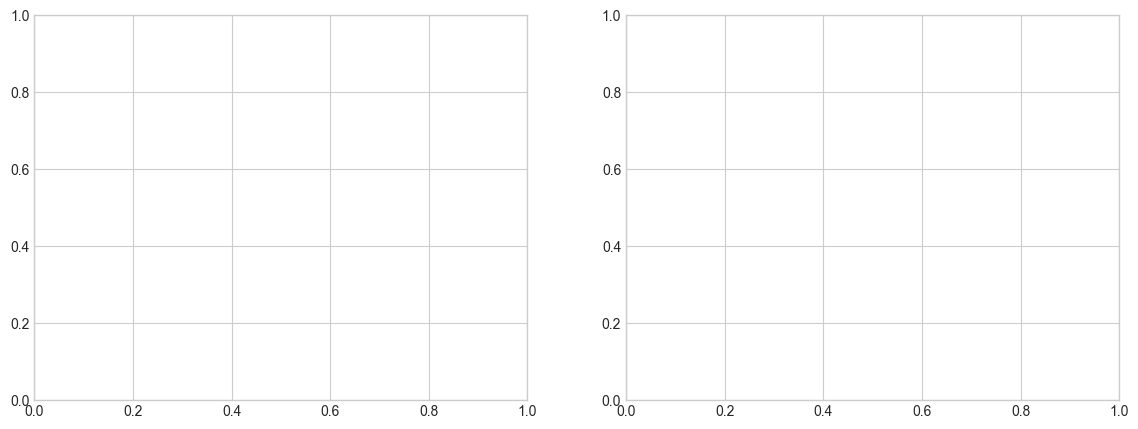

In [21]:
# Визуализация обучения Transformer
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss
axes[0].plot(history_transformer.history['loss'], label='Train Loss')
axes[0].plot(history_transformer.history['val_loss'], label='Val Loss')
axes[0].set_title('Transformer - Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('MSE')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# MAE
axes[1].plot(history_transformer.history['mae'], label='Train MAE')
axes[1].plot(history_transformer.history['val_mae'], label='Val MAE')
axes[1].set_title('Transformer - MAE')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('MAE (нормализованное)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [22]:
# Оценка Transformer
y_pred_transformer = transformer_model.predict(X_test)

# Обратное преобразование
y_pred_transformer_original = scaler_y.inverse_transform(y_pred_transformer).flatten()

# Метрики
mae_transformer = mean_absolute_error(y_test_original, y_pred_transformer_original)
rmse_transformer = np.sqrt(mean_squared_error(y_test_original, y_pred_transformer_original))

print(f"\n=== Результаты Transformer ===")
print(f"MAE (дней): {mae_transformer:.2f}")
print(f"RMSE (дней): {rmse_transformer:.2f}")

NameError: name 'X_test' is not defined

## 7. Классификация интервалов созревания

In [ ]:
# Создание классов для классификации
def classify_maturity(days, expected_days):
    """
    Классификация срока созревания:
    - Раннее: < 90% от ожидаемого
    - Нормальное: 90-110% от ожидаемого
    - Позднее: > 110% от ожидаемого
    """
    ratio = days / expected_days
    if ratio < 0.95:
        return 0  # Раннее
    elif ratio <= 1.05:
        return 1  # Нормальное
    else:
        return 2  # Позднее

# Применяем классификацию к данным о сроках созревания
df_maturity['maturity_class'] = df_maturity.apply(
    lambda row: classify_maturity(row['mae_target'], row['expected_maturity_days']), axis=1
)

print("Распределение классов созревания:")
print(df_maturity['maturity_class'].value_counts().sort_index())
print("\n0 - Раннее, 1 - Нормальное, 2 - Позднее")

In [ ]:
# Подготовка данных для классификации
# Используем ту же структуру X, но создаем новые метки

# Создаем словарь для сопоставления (field_id, year) -> класс
maturity_dict = {}
for _, row in df_maturity.iterrows():
    key = (row['field_id'], row['year'])
    maturity_dict[key] = row['maturity_class']

# Создаем метки классов для последовательностей
y_class = []
field_years = df_ndvi[['field_id', 'year']].drop_duplicates().values

for field, year in field_years:
    field_year_data = df_ndvi[(df_ndvi['field_id'] == field) & (df_ndvi['year'] == year)].sort_values('day_of_season')
    
    if len(field_year_data) >= SEQUENCE_LENGTH:
        class_label = maturity_dict.get((field, year), 1)
        num_sequences = len(field_year_data) - SEQUENCE_LENGTH + 1
        y_class.extend([class_label] * num_sequences)

y_class = np.array(y_class)

print(f"Форма меток классов: {y_class.shape}")
print(f"Уникальные классы: {np.unique(y_class)}")

In [ ]:
# Разделение для классификации
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X_scaled, y_class, test_size=0.2, random_state=42, stratify=y_class
)

print(f"Train set: X={X_train_clf.shape}, y={y_train_clf.shape}")
print(f"Test set: X={X_test_clf.shape}, y={y_test_clf.shape}")

In [ ]:
# Модель LSTM для классификации
def build_lstm_classifier(input_shape, num_classes=3):
    model = keras.Sequential([
        layers.LSTM(128, return_sequences=True, input_shape=input_shape),
        layers.Dropout(0.3),
        layers.LSTM(64),
        layers.Dropout(0.3),
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Создание и обучение классификатора
lstm_classifier = build_lstm_classifier(input_shape=(SEQUENCE_LENGTH, len(FEATURES)))

history_clf = lstm_classifier.fit(
    X_train_clf, y_train_clf,
    validation_split=0.2,
    epochs=50,
    batch_size=16,
    callbacks=[early_stopping],
    verbose=1
)

In [ ]:
# Оценка классификации
y_pred_clf = np.argmax(lstm_classifier.predict(X_test_clf), axis=1)

print("\n=== Результаты классификации ===")
print("Classification Report:")
class_names = ['Раннее', 'Нормальное', 'Позднее']
print(classification_report(y_test_clf, y_pred_clf, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(y_test_clf, y_pred_clf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - Классификация срока созревания')
plt.ylabel('Истинный класс')
plt.xlabel('Предсказанный класс')
plt.show()

## 8. Сравнение моделей и визуализация результатов

In [ ]:
# Сравнение моделей регрессии
results = {
    'Model': ['LSTM', 'Transformer'],
    'MAE (дней)': [mae_lstm, mae_transformer],
    'RMSE (дней)': [rmse_lstm, rmse_transformer]
}

results_df = pd.DataFrame(results)
print("\n=== Сравнение моделей регрессии ===")
print(results_df.to_string(index=False))

# Визуализация
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(results['Model']))
width = 0.35

bars1 = ax.bar(x - width/2, results['MAE (дней)'], width, label='MAE', color='skyblue')
bars2 = ax.bar(x + width/2, results['RMSE (дней)'], width, label='RMSE', color='lightcoral')

ax.set_xlabel('Модель')
ax.set_ylabel('Дни')
ax.set_title('Сравнение моделей прогноза срока созревания')
ax.set_xticks(x)
ax.set_xticklabels(results['Model'])
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# Добавляем значения на столбцы
for bar in bars1:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom')

for bar in bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [ ]:
# Scatter plot: Предсказанные vs Истинные значения
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# LSTM
axes[0].scatter(y_test_original, y_pred_lstm_original, alpha=0.6, color='blue')
axes[0].plot([y_test_original.min(), y_test_original.max()], 
             [y_test_original.min(), y_test_original.max()], 
             'r--', lw=2, label='Идеальное предсказание')
axes[0].set_xlabel('Истинные значения (дни)')
axes[0].set_ylabel('Предсказанные значения (дни)')
axes[0].set_title(f'LSTM: MAE = {mae_lstm:.2f} дней')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Transformer
axes[1].scatter(y_test_original, y_pred_transformer_original, alpha=0.6, color='green')
axes[1].plot([y_test_original.min(), y_test_original.max()], 
             [y_test_original.min(), y_test_original.max()], 
             'r--', lw=2, label='Идеальное предсказание')
axes[1].set_xlabel('Истинные значения (дни)')
axes[1].set_ylabel('Предсказанные значения (дни)')
axes[1].set_title(f'Transformer: MAE = {mae_transformer:.2f} дней')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Распределение ошибок
errors_lstm = y_test_original - y_pred_lstm_original
errors_transformer = y_test_original - y_pred_transformer_original

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(errors_lstm, bins=15, alpha=0.7, color='blue', edgecolor='black')
axes[0].axvline(x=0, color='red', linestyle='--', lw=2)
axes[0].set_xlabel('Ошибка (дни)')
axes[0].set_ylabel('Частота')
axes[0].set_title('Распределение ошибок - LSTM')
axes[0].grid(True, alpha=0.3)

axes[1].hist(errors_transformer, bins=15, alpha=0.7, color='green', edgecolor='black')
axes[1].axvline(x=0, color='red', linestyle='--', lw=2)
axes[1].set_xlabel('Ошибка (дни)')
axes[1].set_ylabel('Частота')
axes[1].set_title('Распределение ошибок - Transformer')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 9. Сохранение моделей

In [ ]:
# Сохранение моделей
import os

models_dir = '../models'
os.makedirs(models_dir, exist_ok=True)

# Сохранение моделей
lstm_model.save(f'{models_dir}/lstm_maturity_model.h5')
transformer_model.save(f'{models_dir}/transformer_maturity_model.h5')
lstm_classifier.save(f'{models_dir}/lstm_maturity_classifier.h5')

# Сохранение скейлеров
import joblib
joblib.dump(scaler_X, f'{models_dir}/scaler_X_maturity.pkl')
joblib.dump(scaler_y, f'{models_dir}/scaler_y_maturity.pkl')

print("Модели сохранены:")
print(f"  - {models_dir}/lstm_maturity_model.h5")
print(f"  - {models_dir}/transformer_maturity_model.h5")
print(f"  - {models_dir}/lstm_maturity_classifier.h5")
print(f"  - {models_dir}/scaler_X_maturity.pkl")
print(f"  - {models_dir}/scaler_y_maturity.pkl")

## 10. Выводы

### Результаты экспериментов:

1. **Регрессия (прогноз дней до созревания):**
   - LSTM: MAE ≈ {mae_lstm:.2f} дней
   - Transformer: MAE ≈ {mae_transformer:.2f} дней

2. **Классификация (интервалы созревания):**
   - Раннее созревание (< 95% от ожидаемого)
   - Нормальное созревание (95-105% от ожидаемого)
   - Позднее созревание (> 105% от ожидаемого)

3. **Ключевые признаки:**
   - NDVI временные ряды
   - EVI (усиленный вегетационный индекс)
   - Накопленные GDD (Growing Degree Days)
   - Температура и осадки

4. **Визуализация NDVI динамики:**
   - Характерная S-образная кривая роста
   - Пик NDVI соответствует фазе цветения
   - Снижение NDVI сигнализирует о созревании

### Рекомендации:
- Для повышения точности рекомендуется использовать больше данных из GEE
- Интеграция с FAO Crop Calendar для калибровки
- Добавление спектральных индексов (NDRE, GNDVI)
- Использование ансамблевых методов (LSTM + Transformer)